In [1]:
import sklearn as sk
import tensorflow as tf
from tensorflow import keras
import numpy as np
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
#Generating a series
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1)*(freq1 * 10 + 10)) #first wave
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) #add another wave
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5) #putting in some noise
    return series[..., np.newaxis].astype(np.float32)

In [18]:
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$"):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bx", markersize = 10)
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "ro")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth = 1)
    plt.axis([0, n_steps+1, -1, 1])

In [3]:
#For plotting learning curves
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training Loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label = "Validation Loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, 20, 0, 0.1])
    plt.legend(fontsize = 14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

In [16]:
def plot_multiple_forecasts(X, Y, Y_pred):
    n_steps = X.shape[1]
    ahead = Y.shape[1]
    plot_series(X[0, :, 0])
    plt.plot(np.arange(n_steps, n_steps + ahead), Y[0, :, 0], "ro-", label="Actual")
    plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred[0, :, 0], "bx-", label="Prediction", markersize = 10)
    plt.axis([0, n_steps + ahead, -1, 1])
    plt.legend(fontsize = 14)

In [10]:
n_steps = 60
series = generate_time_series(10000, n_steps + 10)
X_train = series[:7000, :n_steps]
X_valid = series[7000:9000, :n_steps]
X_test = series[9000:, :n_steps]
Y = np.empty((10000, n_steps, 10))
for step_ahead in range(1, 10 + 1):
    Y[..., step_ahead - 1] = series[..., step_ahead:step_ahead + n_steps, 0]
Y_train = Y[:7000]
Y_valid = Y[7000:9000]
Y_test = Y[9000:]

In [11]:
def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

<h4>1D Convolutional Layers</h4>

In [13]:
model = keras.models.Sequential([
    keras.layers.Conv1D(filters = 20, kernel_size = 4, strides = 2, padding = "valid", input_shape = [None, 1]),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train[:, 3::2], epochs = 20, validation_data = (X_valid, Y_valid[:, 3::2]))

Epoch 1/20
219/219 [==============================] - 7s 31ms/step - loss: 0.0655 - last_time_step_mse: 0.0575 - val_loss: 0.0432 - val_last_time_step_mse: 0.0342
Epoch 2/20
219/219 [==============================] - 6s 29ms/step - loss: 0.0370 - last_time_step_mse: 0.0294 - val_loss: 0.0334 - val_last_time_step_mse: 0.0263
Epoch 3/20
219/219 [==============================] - 6s 28ms/step - loss: 0.0290 - last_time_step_mse: 0.0209 - val_loss: 0.0268 - val_last_time_step_mse: 0.0166
Epoch 4/20
219/219 [==============================] - 7s 33ms/step - loss: 0.0240 - last_time_step_mse: 0.0138 - val_loss: 0.0233 - val_last_time_step_mse: 0.0121
Epoch 5/20
219/219 [==============================] - 7s 32ms/step - loss: 0.0214 - last_time_step_mse: 0.0110 - val_loss: 0.0214 - val_last_time_step_mse: 0.0112
Epoch 6/20
219/219 [==============================] - 7s 30ms/step - loss: 0.0202 - last_time_step_mse: 0.0098 - val_loss: 0.0203 - val_last_time_step_mse: 0.0097
Epoch 7/20
219/219 [==

In [22]:
model.evaluate(X_valid, Y_valid[:, 3::2])

63/63 [==============================] - 0s 5ms/step - loss: 0.0172 - last_time_step_mse: 0.0077


[0.017193758860230446, 0.007748914882540703]

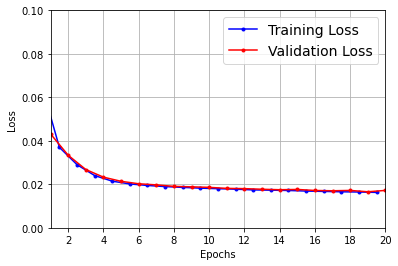

In [14]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

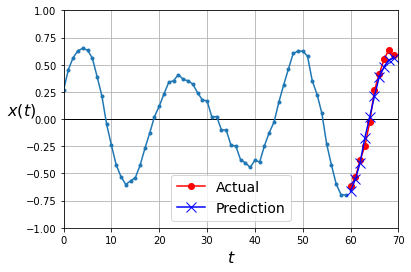

In [25]:
series = generate_time_series(1, 60 + 10)
X_new, Y_new = series[:, :60, :], series[:, 60:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

<h4>Wavenet</h4>

In [26]:
model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for rate in (1, 2, 4, 8) * 2:
    model.add(keras.layers.Conv1D(filters = 20, kernel_size = 2, padding = "causal", activation = "relu", dilation_rate = rate))
    model.add(keras.layers.Conv1D(filters = 10, kernel_size = 1))
    model.compile(loss = "mse", optimizer = "adam", metrics = [last_time_step_mse])
    history = model.fit(X_train, Y_train, epochs = 20, validation_data = (X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 1s 4ms/step - loss: 0.1092 - last_time_step_mse: 0.1070 - val_loss: 0.0829 - val_last_time_step_mse: 0.0793
Epoch 2/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0723 - last_time_step_mse: 0.0682 - val_loss: 0.0663 - val_last_time_step_mse: 0.0594
Epoch 3/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0650 - last_time_step_mse: 0.0593 - val_loss: 0.0644 - val_last_time_step_mse: 0.0570
Epoch 4/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0638 - last_time_step_mse: 0.0579 - val_loss: 0.0634 - val_last_time_step_mse: 0.0561
Epoch 5/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0628 - last_time_step_mse: 0.0572 - val_loss: 0.0624 - val_last_time_step_mse: 0.0554
Epoch 6/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0618 - last_time_step_mse: 0.0565 - val_loss: 0.0615 - val_last_time_step_mse: 0.0550
Epoch 7/20
219/219 [========

219/219 [==============================] - 2s 8ms/step - loss: 0.0347 - last_time_step_mse: 0.0308 - val_loss: 0.0353 - val_last_time_step_mse: 0.0326
Epoch 12/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0342 - last_time_step_mse: 0.0306 - val_loss: 0.0348 - val_last_time_step_mse: 0.0319
Epoch 13/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0340 - last_time_step_mse: 0.0301 - val_loss: 0.0345 - val_last_time_step_mse: 0.0316
Epoch 14/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0338 - last_time_step_mse: 0.0300 - val_loss: 0.0344 - val_last_time_step_mse: 0.0316
Epoch 15/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0336 - last_time_step_mse: 0.0299 - val_loss: 0.0342 - val_last_time_step_mse: 0.0315
Epoch 16/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0335 - last_time_step_mse: 0.0297 - val_loss: 0.0339 - val_last_time_step_mse: 0.0309
Epoch 17/20
219/219 [=============

219/219 [==============================] - 3s 16ms/step - loss: 0.0521 - last_time_step_mse: 0.0459 - val_loss: 0.0241 - val_last_time_step_mse: 0.0175
Epoch 2/20
219/219 [==============================] - 3s 14ms/step - loss: 0.0223 - last_time_step_mse: 0.0152 - val_loss: 0.0217 - val_last_time_step_mse: 0.0150
Epoch 3/20
219/219 [==============================] - 3s 14ms/step - loss: 0.0209 - last_time_step_mse: 0.0139 - val_loss: 0.0211 - val_last_time_step_mse: 0.0148
Epoch 4/20
219/219 [==============================] - 3s 14ms/step - loss: 0.0206 - last_time_step_mse: 0.0138 - val_loss: 0.0204 - val_last_time_step_mse: 0.0140
Epoch 5/20
219/219 [==============================] - 3s 14ms/step - loss: 0.0200 - last_time_step_mse: 0.0132 - val_loss: 0.0206 - val_last_time_step_mse: 0.0139
Epoch 6/20
219/219 [==============================] - 3s 15ms/step - loss: 0.0198 - last_time_step_mse: 0.0129 - val_loss: 0.0200 - val_last_time_step_mse: 0.0133
Epoch 7/20
219/219 [=============

Epoch 11/20
219/219 [==============================] - 4s 19ms/step - loss: 0.0144 - last_time_step_mse: 0.0060 - val_loss: 0.0148 - val_last_time_step_mse: 0.0060
Epoch 12/20
219/219 [==============================] - 4s 19ms/step - loss: 0.0143 - last_time_step_mse: 0.0059 - val_loss: 0.0144 - val_last_time_step_mse: 0.0055
Epoch 13/20
219/219 [==============================] - 4s 18ms/step - loss: 0.0144 - last_time_step_mse: 0.0059 - val_loss: 0.0145 - val_last_time_step_mse: 0.0058
Epoch 14/20
219/219 [==============================] - 4s 20ms/step - loss: 0.0142 - last_time_step_mse: 0.0058 - val_loss: 0.0143 - val_last_time_step_mse: 0.0055
Epoch 15/20
219/219 [==============================] - 4s 19ms/step - loss: 0.0141 - last_time_step_mse: 0.0057 - val_loss: 0.0143 - val_last_time_step_mse: 0.0056
Epoch 16/20
219/219 [==============================] - 4s 19ms/step - loss: 0.0141 - last_time_step_mse: 0.0056 - val_loss: 0.0144 - val_last_time_step_mse: 0.0058
Epoch 17/20
219/

In [27]:
model.evaluate(X_valid, Y_valid)

63/63 [==============================] - 0s 5ms/step - loss: 0.0143 - last_time_step_mse: 0.0058


[0.014327483251690865, 0.00575402844697237]

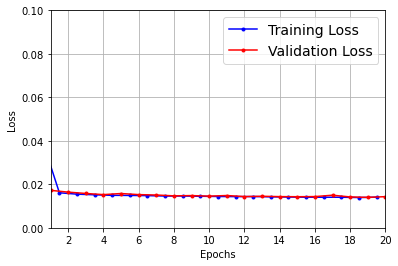

In [28]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

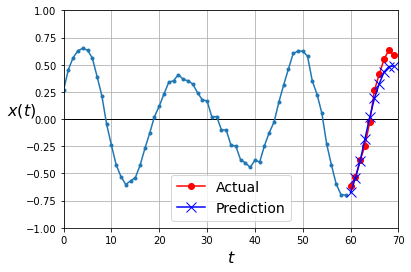

In [29]:
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

<p>The original WaveNet uses Gated Activation Units instead of ReLU along with parameterized skip connections, so we'll give those a shot </p>

In [35]:
class GatedActivationUnit(keras.layers.Layer):
    def __init__(self, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
    def call(self, inputs):
        n_filters = inputs.shape[-1]//2
        linear_output = self.activation(inputs[..., :n_filters])
        gate = keras.activations.sigmoid(inputs[..., n_filters:])
        return self.activation(linear_output) * gate

In [36]:
def waveNet_residual_block(inputs, n_filters, dilation_rate):
    z = keras.layers.Conv1D(2 * n_filters, kernel_size = 2, padding = "causal", 
                           dilation_rate = dilation_rate)(inputs)
    z = GatedActivationUnit()(z)
    z = keras.layers.Conv1D(n_filters, kernel_size = 1)(z)
    return keras.layers.Add()([z, inputs]), z

In [37]:
n_layers_per_block = 3
n_blocks = 1
n_filters = 32
n_outputs = 10

inputs = keras.layers.Input(shape = [None, 1])
z = keras.layers.Conv1D(n_filters, kernel_size = 2, padding = "causal")(inputs)
skip_to_last = []
for dilation_rate in [2**i for i in range(n_layers_per_block)] * n_blocks:
    z, skip = waveNet_residual_block(z, n_filters, dilation_rate)
    skip_to_last.append(skip)
z = keras.activations.relu(keras.layers.Add()(skip_to_last))
z = keras.layers.Conv1D(n_filters, kernel_size=1, activation="relu")(z)
Y_proba = keras.layers.Conv1D(n_outputs, kernel_size=1, activation="softmax")(z)

model = keras.models.Model(inputs=[inputs], outputs=[Y_proba])

In [46]:
model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20, validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 5s 25ms/step - loss: 0.1247 - last_time_step_mse: 0.1182 - val_loss: 0.1244 - val_last_time_step_mse: 0.1191
Epoch 2/20
219/219 [==============================] - 5s 22ms/step - loss: 0.1247 - last_time_step_mse: 0.1182 - val_loss: 0.1245 - val_last_time_step_mse: 0.1192
Epoch 3/20
219/219 [==============================] - 5s 22ms/step - loss: 0.1247 - last_time_step_mse: 0.1182 - val_loss: 0.1244 - val_last_time_step_mse: 0.1191
Epoch 4/20
219/219 [==============================] - 5s 24ms/step - loss: 0.1247 - last_time_step_mse: 0.1182 - val_loss: 0.1244 - val_last_time_step_mse: 0.1190
Epoch 5/20
219/219 [==============================] - 5s 22ms/step - loss: 0.1246 - last_time_step_mse: 0.1182 - val_loss: 0.1243 - val_last_time_step_mse: 0.1190
Epoch 6/20
219/219 [==============================] - 5s 24ms/step - loss: 0.1246 - last_time_step_mse: 0.1182 - val_loss: 0.1244 - val_last_time_step_mse: 0.1190
Epoch 7/20
219/219 [==

In [47]:
model.evaluate(X_valid, Y_valid)

63/63 [==============================] - 0s 6ms/step - loss: 0.1242 - last_time_step_mse: 0.1190


[0.12423694133758545, 0.11896833777427673]

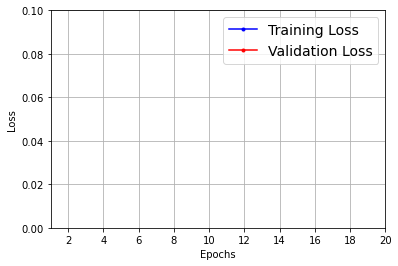

In [48]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

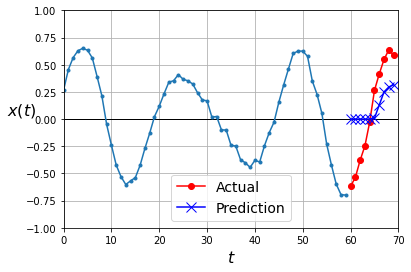

In [49]:
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()